In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from dpp.data import load_from_kaggle


In [ ]:
dataset_link = "gagandeep16/car-sales" # replace with your dataset link from Kaggle 
destination = "../data/raw"
dataset_name = dataset_link.split("/")[-1]

files = load_from_kaggle(
    dataset_link=dataset_link, 
    destination=destination,
    )

In [ ]:
files

In [ ]:
# Load Dataset
df = pd.read_csv("/".join(["../data/raw/", dataset_name, files[0]]))
df.head()

In [ ]:
# Inspect Dataset
display(
    "Shape",
    df.shape,
    "Description",
    df.describe().round(2),
    "Duplicates",
    df.duplicated().sum(),
)


pd.DataFrame(
    {
        "Data Types": df.dtypes,
        "Missing Values": df.isnull().sum(),
        "Unique Values": df.nunique(),
        "Sample Values": [df[col].sample(3).tolist() for col in df.columns]
    })


In [ ]:
df.info()
display(df.describe())

In [ ]:
# Remaning Column
# Renaming __year_resale_value column
if "__year_resale_value" in df.columns:
    df.rename(columns={"__year_resale_value": "Year_resale_value"}, inplace=True)

In [ ]:
# Modifying data types of respective object columns to categorical columns and datetime

category_col = ["Manufacturer","Model","Vehicle_type"]
for col in category_col:
    df[col] = df[col].astype("category")

df["Latest_Launch"] = pd.to_datetime(df["Latest_Launch"], errors = "coerce")

In [ ]:
# Drop Model column
df.drop(['Model'], axis = 1, inplace = True)
df

In [ ]:
# Handling missing values in year_resale_value column
df["Year_resale_value"] = df["Year_resale_value"].fillna(df["Year_resale_value"].median())

In [ ]:
new_df = df[df["Price_in_thousands"].isna()]
new_df

In [ ]:
# Drop Chrysler Town & Country row
df = df.drop(index = 33)

# Fill Acura CL missing values with median
df["Price_in_thousands"] = df["Price_in_thousands"].fillna(df["Price_in_thousands"].median())
df["Power_perf_factor"] = df["Power_perf_factor"].fillna(df["Power_perf_factor"].median())


In [ ]:
new_df = df[df["Curb_weight"].isna()]
new_df

In [ ]:
# Linear Regression model to replace missing Curb_weight value

# Choose predictors for Curb_weight
features = ["Length", "Width", "Engine_size", "Horsepower", "Wheelbase", "Fuel_capacity"]

# Split data into rows with and without Curb_weight
train_data = df[df["Curb_weight"].notnull()]
test_data = df[df["Curb_weight"].isnull()]

# Save indices of missing rows
missing_idx = test_data.index

# Prepare training data
X_train = train_data[features]
y_train = train_data["Curb_weight"]

# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing Curb_weight
X_test = test_data[features]
predicted_values = model.predict(X_test)

# Assign predictions back
df.loc[missing_idx, "Curb_weight"] = predicted_values

# Print imputed rows horizontally
print("Rows imputed using regression:")
display(df.loc[missing_idx])


In [ ]:
# Curb_weight replaced using median
# Create a copy of the original DataFrame to hold the results
#df_median = df.copy()

# Calculate the median of the existing (notnull) 'Curb_weight' values.
#df_median["Curb_weight"] = df_median["Curb_weight"].fillna(df_median["Curb_weight"].median())

# Display the rows that were imputed
#df_median.loc[[15]]

In [ ]:
new_df = df[df["Fuel_efficiency"].isna()]
new_df

In [ ]:
# Linear Regression model to replace missing Fuel_efficency value

# Choose predictors for Fuel_efficiency
features = ["Engine_size", "Horsepower", "Curb_weight"]

# Split data into rows with and without Fuel_efficiency
train_data = df[df["Fuel_efficiency"].notnull()]
test_data  = df[df["Fuel_efficiency"].isnull()]

# Save indices of missing rows
missing_idx = test_data.index

# Prepare training data
X_train = train_data[features]
y_train = train_data["Fuel_efficiency"]

# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing Fuel_efficiency values
X_test = test_data[features]
predicted_values = model.predict(X_test)

# Assign predictions back
df.loc[missing_idx, "Fuel_efficiency"] = predicted_values

# Print imputed rows horizontally
print("Rows imputed using regression:")
display(df.loc[missing_idx])

In [ ]:
display(df.describe().round(2))
df.info()

In [ ]:
# Univariate Analysis
# Numeric Columns Analysis
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    skewness = df[col].skew()

    print(f"\nColumn: {col}")
    print(f"Skewness: {skewness:.2f}")
    
    if skewness > 1:
        print("Highly right-skewed")
    elif skewness > 0.5:
        print("Moderately right-skewed")
    elif skewness < -1:
        print("Highly left-skewed")
    elif skewness < -0.5:
        print("Moderately left-skewed")
    else:
        print("Approximately symmetric")
    
    plt.figure(figsize=(12,4))
    
    # Histogram with KDE
    plt.subplot(1,2,1)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f"Histogram of {col}")
    
    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")
    
    plt.show()


In [ ]:
# Categorical Feature Analysis
cat_cols = df.select_dtypes(include='category')

for col in cat_cols:
    plt.figure(figsize=(15,6))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
# Bivariate Analysis
# Correlation heatmap for numeric variables

numeric_cols = df.select_dtypes(include=np.number).columns
print(numeric_cols)
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", center=0, fmt='.1f');
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [ ]:
# Price Analysis (Categorical Features)
# Does Manufacturer significantly influence Price

# Manufacturer vs Price (Boxplot)
plt.figure(figsize=(20,6))
sns.boxplot(data=df, x="Manufacturer", y="Price_in_thousands", hue="Manufacturer", 
            palette='Set3');
plt.xticks(rotation=45)
plt.title("Price Distribution by Manufacturer")
plt.xlabel("Manufacturer")
plt.ylabel("Price (in thousands)")
plt.tight_layout()
plt.show()

# Which manufacturer has the highest average Price
# Average Price per Manufacturer (Barplot)
plt.figure(figsize=(20,6))

# Aggregate and sort by average price
manufacturer_price_df = (df.groupby('Manufacturer', observed=True)['Price_in_thousands']
                         .mean().sort_values(ascending=False).reset_index())

# Extract the sorted list of Manufacturer names for explicit order
manufacturer_order_list = manufacturer_price_df['Manufacturer']

plt.figure(figsize=(20,6))
# Plotting the pre-sorted DataFrame with explicit order
sns.barplot(
    data=manufacturer_price_df,
    x="Manufacturer",
    y="Price_in_thousands",
    order=manufacturer_order_list,  # guarantees sorting
    hue="Manufacturer",
    legend=False,
    palette='viridis'
);

plt.xticks(rotation=45, ha='right')
plt.title("Average Price per Manufacturer (Sorted by Price)", fontsize=14)
plt.xlabel("Manufacturer")
plt.ylabel("Average Price (in thousands)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Are prices linked to Vehicle_Type? (Boxplot for Price Distribution)
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="Vehicle_type", y="Price_in_thousands", hue="Vehicle_type", palette='Set2');
plt.title("Price Distribution by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Price (in thousands)")
plt.show()


# Vehicle Type vs Average Price (Barplot)
plt.figure(figsize=(10,4))
sns.barplot(data=df, x='Vehicle_type', y='Price_in_thousands', hue='Vehicle_type', errorbar=None, palette='viridis');
plt.title("Average Price by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Average Price (in thousands)")
plt.show()

In [ ]:
# What features influence car prices the most?

numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numeric_cols].corr().round(1)         # Correlation matrix

# Extract correlations with Price
price_corr = corr_matrix["Price_in_thousands"].drop("Price_in_thousands")

# Select features with |correlation| >= 0.5
selected_price_features = price_corr[price_corr.abs() >= 0.5].index.tolist()
print("Selected price-driving features:", selected_price_features)

# Pairplot of selected features + Price
sns.pairplot(df[selected_price_features + ["Price_in_thousands"]])
plt.suptitle("Pairplots of Selected Numeric Features vs Price", y=1)
plt.show()

# Scatterplots: all selected features vs Price in one figure
n_features = len(selected_price_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # auto-calc rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(selected_price_features):
    sns.scatterplot(x=feature, y="Price_in_thousands", data=df, ax=axes[i], alpha=0.7)
    axes[i].set_title(f"{feature} vs Price")

# Hide unused axes (if features < grid size)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# How does Horsepower relate to Price
# Scatterplot + Regression line: Horsepower vs Price by Vehicle_Type

if 'Horsepower' in df.columns and 'Price_in_thousands' in df.columns:
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df, x='Horsepower', y='Price_in_thousands', hue='Vehicle_type', alpha=0.7)
    sns.regplot(data=df, x='Horsepower', y='Price_in_thousands', scatter=False, color='red')
    plt.title("Horsepower vs Price")
    plt.xlabel("Horsepower")
    plt.ylabel("Price (in thousands)")
    plt.legend(title="Vehicle Type", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [ ]:
# Power_perf_factor vs. Key Business Metrics
# Addresses: Performance correlation with Price, Sales, and Resale.

# Define target variables
targets = ['Price_in_thousands', 'Sales_in_thousands', 'Year_resale_value']

for target in targets:
    if 'Power_perf_factor' in df.columns and target in df.columns:
        # Scatterplot with regression line
        plt.figure(figsize=(8,6))
        sns.scatterplot(data=df, x='Power_perf_factor', y=target, alpha=0.7)
        sns.regplot(data=df, x='Power_perf_factor', y=target, scatter=False, color='red')
        plt.title(f"Power_perf_factor vs {target}")
        plt.xlabel("Power_perf_factor")
        plt.ylabel(target)
        plt.show()


In [ ]:
# Do more powerful cars command higher prices?
# Ensure required columns exist
required_cols = ['Horsepower', 'Price_in_thousands', 'Engine_size', 'Vehicle_type']
if all(col in df.columns for col in required_cols):

    # Scatterplot: Horsepower vs Price
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=df,
        x='Horsepower',
        y='Price_in_thousands',
        hue='Vehicle_type',       # color by Vehicle Type
        size='Engine_size',       # size by Engine Size
        palette='Set2',
        alpha=0.7,
        sizes=(20, 500)
    )
    
    # Regression line (overall trend)
    sns.regplot(data=df, x='Horsepower', y='Price_in_thousands', scatter=False, color='red')
    
    plt.title("Horsepower vs Price by Vehicle Type (Bubble Size = Engine Size)")
    plt.xlabel("Horsepower")
    plt.ylabel("Price (in thousands)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Vehicle Type / Engine Size")
    plt.tight_layout()
    plt.show()
    

In [ ]:
# Sales Analysis (Categorical Features)
# Does Manufacturer significantly influence Sales

# Manufacturer vs Sales (Boxplot)
plt.figure(figsize=(20,6))
sns.boxplot(data=df, x="Manufacturer", y="Sales_in_thousands", hue='Manufacturer', palette='Set3' )
plt.xticks(rotation=45)
plt.title("Sales by Manufacturer")
plt.xlabel("Manufacturers")
plt.ylabel("Sales (in thousands)")
plt.show()

# Which manufacturer dominates the sales volume
# Average Sales per Manufacturer (Barplot)
plt.figure(figsize=(20,6))

# Aggregate and sort by sales (creates the small, sorted summary table)
manufacturer_sales_df = (df.groupby('Manufacturer', observed=True)['Sales_in_thousands'].sum().sort_values(ascending=False).reset_index())

# Extract the sorted list of Manufacturer names for explicit order
manufacturer_order_list = manufacturer_sales_df['Manufacturer']

# Plotting the PRE-SORTED DataFrame with explicit order
sns.barplot(
    data=manufacturer_sales_df,
    x="Manufacturer",
    y="Sales_in_thousands",
    order=manufacturer_order_list, # GUARANTEES THE SORTING
    hue="Manufacturer", 
    legend=False,
    palette='viridis' 
)

plt.xticks(rotation=45, ha='right')
plt.title("Total Sales Volume per Manufacturer (Sorted by Volume)", fontsize=14)
plt.xlabel("Manufacturer")
plt.ylabel("Total Sales (in thousands)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Are sales linked to Vehicle_Type? (Boxplot for Sales Distribution)
# Vehicle Type vs Sales (Boxplot)
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="Vehicle_type", y="Sales_in_thousands", hue="Vehicle_type", palette='Set2')
plt.xticks()
plt.title("Sales Distribution by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Sales (in thousands)")
plt.show()

# Vehicle Type vs Price (Barplot)
plt.figure(figsize=(10,4))
sns.barplot(x='Vehicle_type', y='Sales_in_thousands', data=df, hue='Vehicle_type', errorbar=None, palette='viridis' )
plt.title(f"Total by Vehicle Type")
plt.show()

In [ ]:
# What is the relationship between Price and Sales

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Price_in_thousands', y='Sales_in_thousands', hue='Vehicle_type',alpha=0.7)
sns.regplot(data=df, x='Price_in_thousands', y='Sales_in_thousands', scatter=False, color='red')
plt.title("Relationship between Price and Sales")
plt.xlabel("Price (in thousands)")
plt.ylabel("Sales (in thousands)")
plt.legend(title='Vehicle Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Do more powerful cars sell better than smaller ones?
# Check required columns exist
required_cols = ['Engine_size', 'Horsepower', 'Sales_in_thousands', 'Vehicle_type']
if all(col in df.columns for col in required_cols):

    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=df,
        x='Engine_size',
        y='Sales_in_thousands',
        size='Horsepower',       # bubble size represents horsepower
        hue='Vehicle_type',      # color represents vehicle type
        alpha=0.7,
        sizes=(20, 200),
        palette='Set2'
    )
    
    # Regression line (overall trend)
    sns.regplot(data=df, x='Engine_size', y='Sales_in_thousands', scatter=False, color='red')
    
    plt.title("Do More Powerful Cars Sell Better?")
    plt.xlabel("Engine Size")
    plt.ylabel("Sales (in thousands)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Vehicle Type / Horsepower")
    plt.tight_layout()
    plt.show()
    

In [ ]:
# Resales Analysis (Categorical Features)
# Does Manufacturer significantly influence Resales

# Manufacturer vs Resales (Boxplot)
plt.figure(figsize=(20,6))
sns.boxplot(x="Manufacturer", y="Year_resale_value", data=df)
plt.xticks(rotation=45)
plt.title("Resale Value by Manufacturer")
plt.xlabel("Manufacturer")
plt.ylabel("Year Resale Value")
plt.show()

# Which manufacturer dominates the resale values
# Average Resales Value per Manufacturer (Barplot)
plt.figure(figsize=(20,6))

# Aggregate and sort by sales (creates the small, sorted summary table)
manufacturer_resale_df = (df.groupby('Manufacturer', observed=True)['Year_resale_value'].mean().sort_values(ascending=False).reset_index())

# Extract the sorted list of Manufacturer names for explicit order
manufacturer_order_list = manufacturer_resale_df['Manufacturer']

# Plotting the PRE-SORTED DataFrame with explicit order
sns.barplot(
    data=manufacturer_resale_df,
    x="Manufacturer",
    y="Year_resale_value",
    order=manufacturer_order_list, # GUARANTEES THE SORTING
    hue="Manufacturer", 
    legend=False,
    palette='viridis' 
)

plt.xticks(rotation=45, ha='right')
plt.title("Average Resale Value per Manufacturer (Sorted)", fontsize=14)
plt.xlabel("Manufacturer")
plt.ylabel("Average Resale Value")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Are resales linked to Vehicle_Type? (Boxplot for ReSale Distribution)
# Vehicle Type vs Sales (Boxplot)
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="Vehicle_type", y="Year_resale_value", hue="Vehicle_type")
plt.xticks()
plt.title("Resale Value Distribution by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Year Resale Value")
plt.show()

# Vehicle Type vs Resale Value (Barplot)
plt.figure(figsize=(10,4))
sns.barplot(x='Vehicle_type', y='Year_resale_value', data=df, hue='Vehicle_type', errorbar=None, palette='viridis' )
plt.title(f"Resale Value by Vehicle Type")
plt.show()

In [ ]:
# Factors influencing car resales

# Step 1: Numeric features including target Resale value
numeric_cols = df.select_dtypes(include=np.number).columns

# Step 2: Correlation matrix
corr_matrix = df[numeric_cols].corr().round(1)

# Step 3: Extract correlations with Resale value
price_corr = corr_matrix["Year_resale_value"].drop("Year_resale_value")

# Step 4: Select features with |correlation| > 0.5
selected_price_features = price_corr[price_corr.abs() >= 0.5].index.tolist()

print("Selected price-driving features:", selected_price_features)

# Pairplot of selected features + Resale value
sns.pairplot(df[selected_price_features + ["Year_resale_value"]])
plt.suptitle("Pairplots of Selected Numeric Features vs Resale Value", y=1.02)
plt.show()

# Scatterplots: all selected features vs Resale value in one figure
n_features = len(selected_price_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # auto-calc rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(selected_price_features):
    sns.scatterplot(x=feature, y="Year_resale_value", data=df, ax=axes[i], alpha=0.7)
    axes[i].set_title(f"{feature} vs Resale Value")

# Hide unused axes (if features < grid size)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# Which manufacturers retain value best?
# Value Retention (% of original price)

if all(col in df.columns for col in ['Manufacturer', 'Price_in_thousands', 'Year_resale_value']):
    
    # Compute Retention Ratio = Resale / Price
    df['Retention_Ratio'] = df['Year_resale_value'] / df['Price_in_thousands']
    
    # Group by manufacturer and calculate average retention ratio
    retention_df = (df.groupby('Manufacturer', observed=True)['Retention_Ratio']
                      .mean()
                      .sort_values(ascending=False)
                      .reset_index())
    
    # Extract sorted manufacturer order
    manu_order = retention_df['Manufacturer']
    
    # Plot results (sorted by Retention_Ratio)
    plt.figure(figsize=(16,6))
    sns.barplot(
        data=retention_df,
        x='Manufacturer',
        y='Retention_Ratio',
        hue='Manufacturer',      # explicit hue
        order=manu_order,        # ensures sorted order
        legend=False,
        palette='viridis'
    )
    plt.xticks(rotation=45, ha='right')
    plt.title("Average Value Retention by Manufacturer", fontsize=14)
    plt.xlabel("Manufacturer")
    plt.ylabel("Average Retention (%)")
    
    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()
   


In [ ]:
# Resale Value Analysis
# Which manufacturers and vehicle types retain value best, and how does a car’s original price affect its 1-year resale value?

required_cols = ['Manufacturer', 'Vehicle_type', 'Price_in_thousands', 'Year_resale_value']
if all(col in df.columns for col in required_cols):

    # 1. Average resale by Manufacturer (sorted descending)
    resale_avg = df.groupby('Manufacturer', observed=False)['Year_resale_value'].mean().sort_values(ascending=False).reset_index()
    
    plt.figure(figsize=(10,12))
    sns.barplot(
        data=resale_avg,
        x='Year_resale_value',
        y='Manufacturer',
        hue='Year_resale_value',
        palette='viridis',
        order=resale_avg['Manufacturer']  # Ensures sorted order
    )
    plt.title("Average 1-Year Resale Value by Manufacturer (Highest to Lowest)")
    plt.xlabel("Average Resale Value (in thousands)")
    plt.ylabel("Manufacturer")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

# Does vehicle type (Passenger vs Car) affect depreciation?
    # 2. Resale by Vehicle Type
    vehicle_types = df['Vehicle_type'].unique()
    plt.figure(figsize=(8,6))
    sns.boxplot(
        data=df,
        x='Vehicle_type',
        y='Year_resale_value',
        hue='Vehicle_type',
        order=vehicle_types,
        palette='Set2'
    )
    plt.title("Resale Value by Vehicle Type")
    plt.xlabel("Vehicle Type")
    plt.ylabel("1-Year Resale Value (in thousands)")
    plt.show()

    # 3. Resale vs Original Price with regression line
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=df,
        x='Price_in_thousands',
        y='Year_resale_value',
        hue='Vehicle_type',
        palette='viridis',
        alpha=0.7
    )
    sns.regplot(
        data=df,
        x='Price_in_thousands',
        y='Year_resale_value',
        scatter=False,
        color='red',
        line_kws={'linewidth':2}
    )
    plt.title("Resale Value vs Original Price")
    plt.xlabel("Original Price (in thousands)")
    plt.ylabel("1-Year Resale Value (in thousands)")
    plt.show()


In [ ]:
# Are higher-priced cars sold less than mid-range or economy cars?
# Ensure Price_Category exists using dataset min/max
min_price = df["Price_in_thousands"].min()
max_price = df["Price_in_thousands"].max()

bins = np.linspace(min_price, max_price, 5)  # 4 intervals
labels = ["Economy","Mid-range","Premium","Luxury"]

df["Price_Category"] = pd.cut(df["Price_in_thousands"], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(8,5))
sns.barplot(
    data=df,
    x="Price_Category",
    y="Sales_in_thousands",
    estimator=np.mean,   # Seaborn calculates average
    hue="Price_Category",
    errorbar=None,
    palette="viridis",
    dodge=False
)
plt.title("Average Sales per Price Category (Per Model)")
plt.xlabel("Price Category")
plt.ylabel("Average Sales (in thousands)")
plt.show()

In [ ]:
# Design and Efficiency Trade-Off
# How do a car’s price and fuel efficiency relate, and does this relationship differ by manufacturer?

# Ensure required columns exist
required_cols = ['Price_in_thousands', 'Fuel_efficiency', 'Manufacturer']
if all(col in df.columns for col in required_cols):

    plt.figure(figsize=(12,7))
    
    # Scatter points colored by Manufacturer
    sns.scatterplot(
        data=df,
        x='Price_in_thousands',
        y='Fuel_efficiency',
        hue='Manufacturer',
        palette='tab20',
        alpha=0.7,
        s=80
    )
    
    # Add regression lines per Manufacturer
    manufacturers = df['Manufacturer'].unique()
    for manu in manufacturers:
        manu_data = df[df['Manufacturer'] == manu]
        sns.regplot(
            data=manu_data,
            x='Price_in_thousands',
            y='Fuel_efficiency',
            scatter=False,
            label=None,  # avoid extra legend entries
            line_kws={'linewidth':1, 'alpha':0.6}
        )
    
    plt.title("Price vs Fuel Efficiency by Manufacturer with Trend Lines")
    plt.xlabel("Price (in thousands)")
    plt.ylabel("Fuel Efficiency (mpg)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Manufacturer")
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
# Design and Efficiency Trade-Off
# How do a car’s price and fuel efficiency relate, and does this relationship differ by Vehicle Type?

# Ensure required columns exist
required_cols = ['Price_in_thousands', 'Fuel_efficiency', 'Vehicle_type']
if all(col in df.columns for col in required_cols):

    plt.figure(figsize=(10,6))
    
    # Scatter points colored by Vehicle Type
    sns.scatterplot(
        data=df,
        x='Price_in_thousands',
        y='Fuel_efficiency',
        hue='Vehicle_type',
        palette='Set2',
        alpha=0.7,
        s=80
    )
    
    # Add regression lines per Vehicle Type
    vehicle_types = df['Vehicle_type'].unique()
    for vtype in vehicle_types:
        vtype_data = df[df['Vehicle_type'] == vtype]
        sns.regplot(
            data=vtype_data,
            x='Price_in_thousands',
            y='Fuel_efficiency',
            scatter=False,
            label=None,  # avoid duplicate legend entries
            line_kws={'linewidth':2, 'alpha':0.6}
        )
    
    plt.title("Price vs Fuel Efficiency by Vehicle Type with Trend Lines")
    plt.xlabel("Price (in thousands)")
    plt.ylabel("Fuel Efficiency (mpg)")
    plt.legend(title="Vehicle Type")
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
# How do design factors (Wheelbase, Width, Length, Curb_weight) influence fuel efficiency?

# Ensure required columns exist
design_cols = ['Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_efficiency']
if all(col in df.columns for col in design_cols):

    # 1. Scatter plots with regression lines
    plt.figure(figsize=(16,12))
    
    for i, col in enumerate(['Wheelbase', 'Width', 'Length', 'Curb_weight']):
        plt.subplot(2, 2, i+1)
        sns.scatterplot(
            data=df,
            x=col,
            y='Fuel_efficiency',
            alpha=0.7,
            color='teal'
        )
        sns.regplot(
            data=df,
            x=col,
            y='Fuel_efficiency',
            scatter=False,
            color='red',
            line_kws={'linewidth':2}
        )
        plt.title(f"{col} vs Fuel Efficiency")
        plt.xlabel(col)
        plt.ylabel("Fuel Efficiency (mpg)")
        plt.grid(alpha=0.4)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Correlation heatmap (optional summary)
    corr_cols = ['Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_efficiency']
    corr_matrix = df[corr_cols].corr()
    
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Correlation Between Design Factors and Fuel Efficiency")
    plt.show()


In [ ]:
# How do design factors (Wheelbase, Width, Length, Curb_weight) influence fuel efficiency?
#pairplot

# Select relevant columns
cols = ['Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_efficiency', 'Vehicle_type']

# Pairplot
sns.pairplot(
    df[cols],
    hue='Vehicle_type',
    palette='Set2',
    diag_kind='kde',        # Kernel density estimate for the diagonal
    plot_kws={'alpha':0.7}  # Transparency for points
)
plt.suptitle("Pairplot of Design Factors vs Fuel Efficiency by Vehicle Type", y=1.02)
plt.show()


In [ ]:
# What is the trade-off between Engine_size and Fuel_efficiency?

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x='Engine_size',
    y='Fuel_efficiency',
    hue='Vehicle_type',   # Color by vehicle type
    palette='Set2',
    alpha=0.7
)

# Optional regression line for overall trend
sns.regplot(
    data=df,
    x='Engine_size',
    y='Fuel_efficiency',
    scatter=False,
    color='red',
    line_kws={'linewidth':2}
)

plt.title("Trade-off between Engine Size and Fuel Efficiency")
plt.xlabel("Engine Size (L)")
plt.ylabel("Fuel Efficiency (mpg)")
plt.show()


In [ ]:
# What is the distribution of vehicle types?

# Count of each vehicle type
vehicle_counts = df['Vehicle_type'].value_counts()

# 1. Bar plot
plt.figure(figsize=(6,5))
sns.countplot(data=df, x='Vehicle_type', hue='Vehicle_type', palette='Set2')
plt.title("Distribution of Vehicle Types")
plt.xlabel("Vehicle Type")
plt.ylabel("Number of Models")
plt.show()

# 2. Pie chart
plt.figure(figsize=(6,6))
plt.pie(vehicle_counts, labels=vehicle_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title("Vehicle Type Distribution")
plt.show()


In [ ]:
# Can cars be clustered into natural groups (economy, family, performance, luxury)?


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select features relevant for clustering
features = ['Price_in_thousands', 'Engine_size', 'Horsepower', 'Fuel_efficiency', 'Curb_weight']
X = df[features].copy()

# Handle missing values (if any)
X = X.fillna(X.mean())

# Standardize features (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Inspect cluster centers
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)
print("Cluster Centers (approximate feature values):")
print(centers)

# Label clusters based on their characteristics
# We analyze the centers to assign meaningful names
cluster_labels = {}
for i, row in centers.iterrows():
    if row['Price_in_thousands'] <= 25 and row['Fuel_efficiency'] >= 25:
        cluster_labels[i] = 'Economy'
    elif row['Price_in_thousands'] <= 40 and row['Curb_weight'] >= 3.3:
        cluster_labels[i] = 'Family'
    elif row['Horsepower'] >= 250:
        cluster_labels[i] = 'Performance'
    else:
        cluster_labels[i] = 'Luxury'

# Map numeric clusters to descriptive labels
df['Cluster_Label'] = df['Cluster'].map(cluster_labels)

# Count of models per cluster
print(df['Cluster_Label'].value_counts())

# Visualize clusters
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df, 
    x='Price_in_thousands', 
    y='Fuel_efficiency', 
    hue='Cluster_Label',
    palette='Set2',
    s=100,
    alpha=0.7
)
plt.title("Car Clusters Based on Features")
plt.xlabel("Price (in thousands)")
plt.ylabel("Fuel Efficiency (mpg)")
plt.legend(title="Cluster")
plt.show()


"""
Explanation of the clusters (based on features):

Economy

Low price, high fuel efficiency, moderate engine size and horsepower.

Example: Small city cars or compact sedans.

Family

Moderate price, higher curb weight, decent fuel efficiency.

Example: SUVs, minivans, or family sedans.

Performance

High horsepower, larger engines, lower fuel efficiency.

Example: Sports cars, performance sedans.

Luxury

High price, moderate fuel efficiency, premium features (not necessarily extreme horsepower).

Example: Luxury sedans, SUVs with comfort-focused features.
"""

In [ ]:

# Are there clusters of top-selling models by price and feature set?
# 5. Clusters / Top-Selling Models
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select relevant features for clustering
X = df[["Price_in_thousands","Sales_in_thousands","Horsepower","Engine_size"]].dropna()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# Visualize clusters
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="Price_in_thousands",
    y="Sales_in_thousands",
    hue="Cluster",
    size="Horsepower",
    data=df,
    palette="tab10",
    alpha=0.7,
    sizes=(50, 400)
)
plt.title("Clusters of Cars by Price, Features & Sales")
plt.show()

# Show top models in each cluster
top_models = df.groupby("Cluster").apply(lambda g: g.nlargest(3, "Sales_in_thousands")[["Manufacturer","Price_in_thousands","Sales_in_thousands"]])
print(top_models)



In [ ]:
# Number of Models
# Total number of unique models in the dataset
total_models = df['Model'].nunique()
print(f"Total unique car models: {total_models}")

# Number of models per manufacturer
models_per_manufacturer = df.groupby('Manufacturer')['Model'].nunique().sort_values(ascending=False)
print(models_per_manufacturer)


Percentage of each Manufacturer in each Cluster:
Manufacturer     Acura       Audi       BMW     Buick   Cadillac  Chevrolet  \
Cluster                                                                       
0             1.562500   1.562500  0.000000  0.000000   0.000000   6.250000   
1             0.000000   0.000000  0.000000  0.000000  23.529412   5.882353   
2             4.411765   1.470588  4.411765  5.882353   1.470588   5.882353   
3             0.000000  14.285714  0.000000  0.000000   0.000000   0.000000   

Manufacturer  Chrysler      Dodge      Ford     Honda  ...  Oldsmobile  \
Cluster                                                ...               
0             4.687500   7.812500  9.375000  4.687500  ...    3.125000   
1             0.000000   5.882353  5.882353  0.000000  ...    5.882353   
2             4.411765   5.882353  5.882353  2.941176  ...    4.411765   
3             0.000000  14.285714  0.000000  0.000000  ...    0.000000   

Manufacturer  Plymouth   Pontia

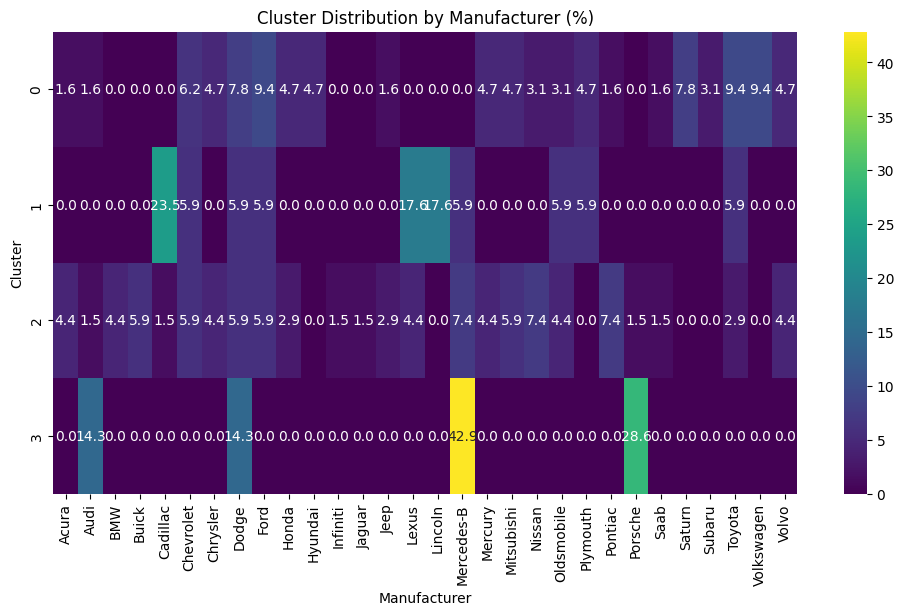

Percentage of each Vehicle_Type in each Cluster:
Vehicle_type        Car   Passenger
Cluster                            
0             17.187500   82.812500
1             35.294118   64.705882
2             33.823529   66.176471
3              0.000000  100.000000


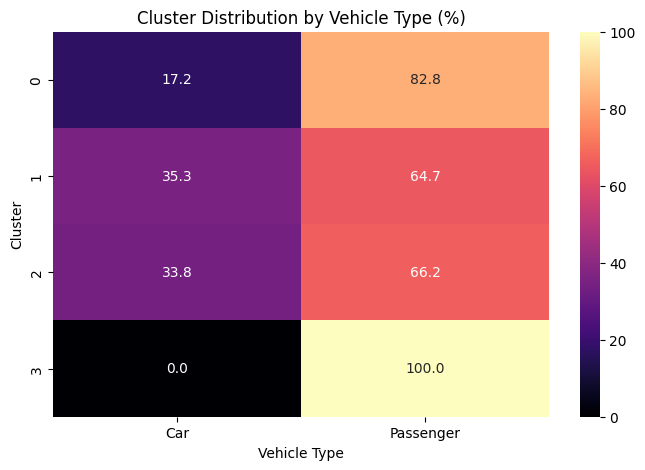

In [50]:
# Are clusters linked to specific Make, Vehicle_Type?


# Assume df already has a 'Cluster' column from previous clustering step
# Example: df['Cluster'] = kmeans.labels_

# -----------------------------
# 1. Check cluster distribution by Manufacturer
cluster_make = pd.crosstab(df['Cluster'], df['Manufacturer'], normalize='index') * 100  # percentage
print("Percentage of each Manufacturer in each Cluster:")
print(cluster_make)

# Optional: heatmap visualization
plt.figure(figsize=(12,6))
sns.heatmap(cluster_make, annot=True, fmt=".1f", cmap="viridis")
plt.title("Cluster Distribution by Manufacturer (%)")
plt.xlabel("Manufacturer")
plt.ylabel("Cluster")
plt.show()

# -----------------------------
# 2. Check cluster distribution by Vehicle_Type
cluster_type = pd.crosstab(df['Cluster'], df['Vehicle_type'], normalize='index') * 100  # percentage
print("Percentage of each Vehicle_Type in each Cluster:")
print(cluster_type)

# Heatmap visualization
plt.figure(figsize=(8,5))
sns.heatmap(cluster_type, annot=True, fmt=".1f", cmap="magma")
plt.title("Cluster Distribution by Vehicle Type (%)")
plt.xlabel("Vehicle Type")
plt.ylabel("Cluster")
plt.show()


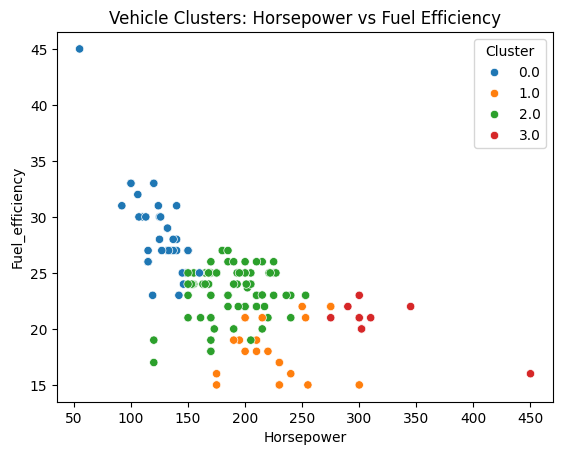

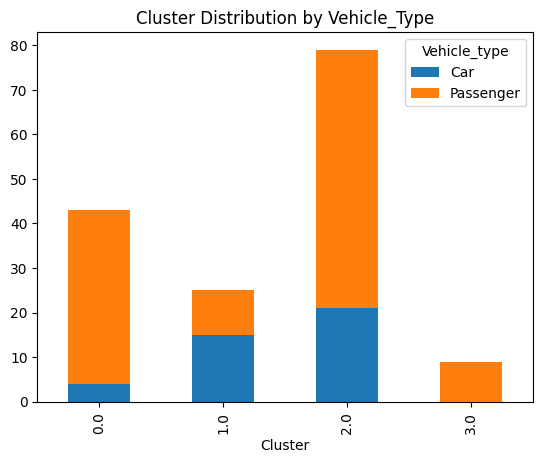

In [52]:
# KMeans clustering
features = ['Price_in_thousands','Horsepower','Engine_size','Fuel_efficiency']
X = df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster'] = np.nan
df.loc[X.index, 'Cluster'] = clusters

# Cluster scatterplot: Horsepower vs Fuel Efficiency
sns.scatterplot(x='Horsepower', y='Fuel_efficiency', hue='Cluster', palette='tab10', data=df)
plt.title("Vehicle Clusters: Horsepower vs Fuel Efficiency")
plt.show()

# Cluster distribution by Vehicle_Type
pd.crosstab(df['Cluster'], df['Vehicle_type']).plot(kind='bar', stacked=True)
plt.title("Cluster Distribution by Vehicle_Type")
plt.show()


/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_55787/1028324170.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_sales, x='Cluster', y='Sales_in_thousands', palette='viridis')


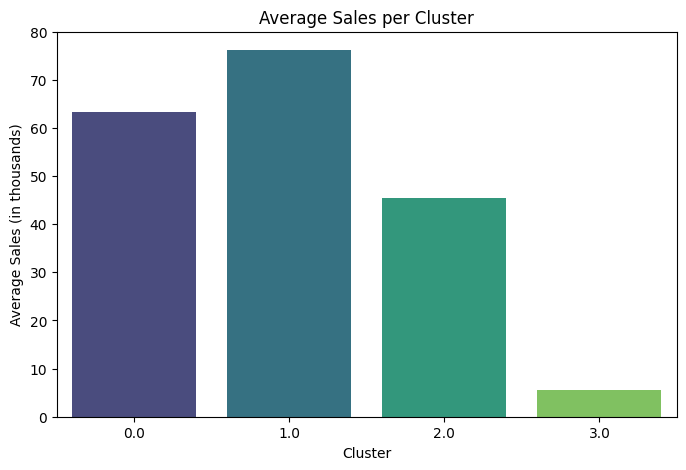

/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_55787/1028324170.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_resale, x='Cluster', y='Year_resale_value', palette='magma')


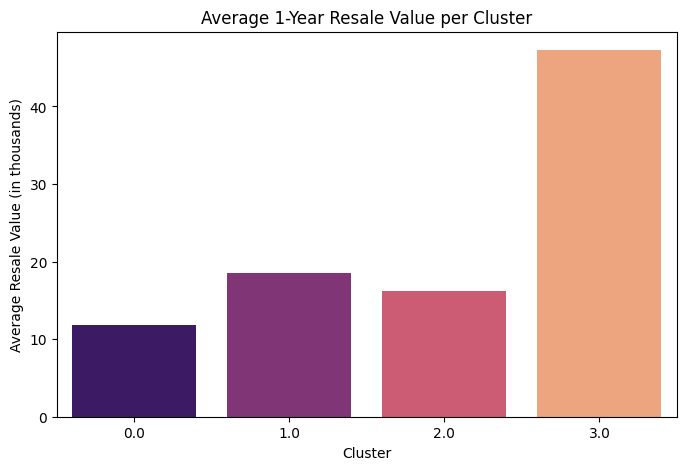

/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_55787/1028324170.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=design_avg, x='Cluster', y=feature, palette='coolwarm', ax=axes[i])
/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_55787/1028324170.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=design_avg, x='Cluster', y=feature, palette='coolwarm', ax=axes[i])
/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_55787/1028324170.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=design_av

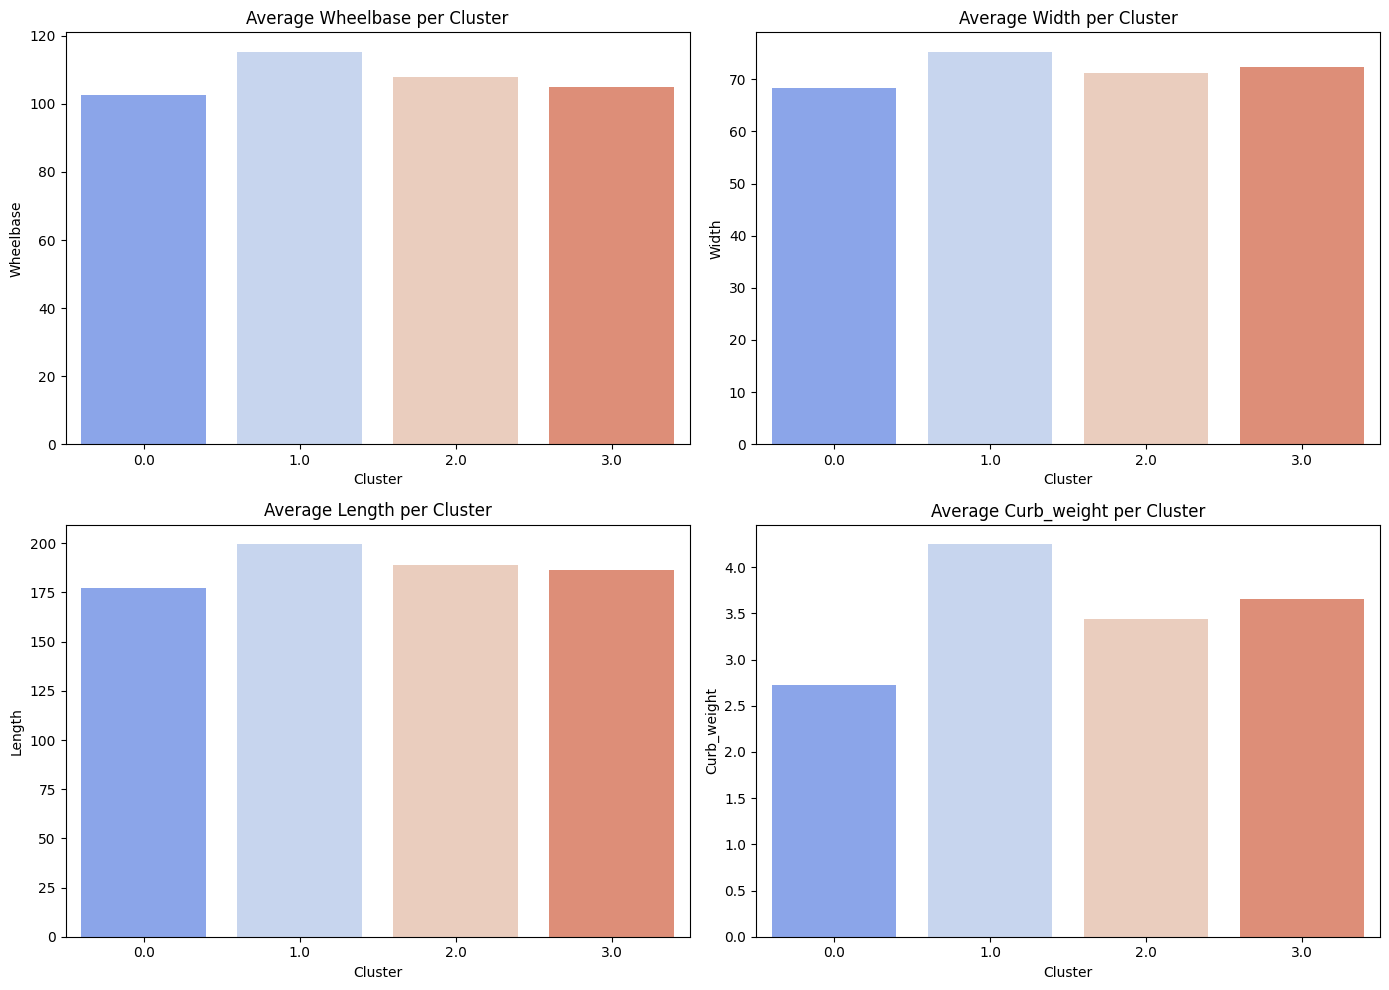

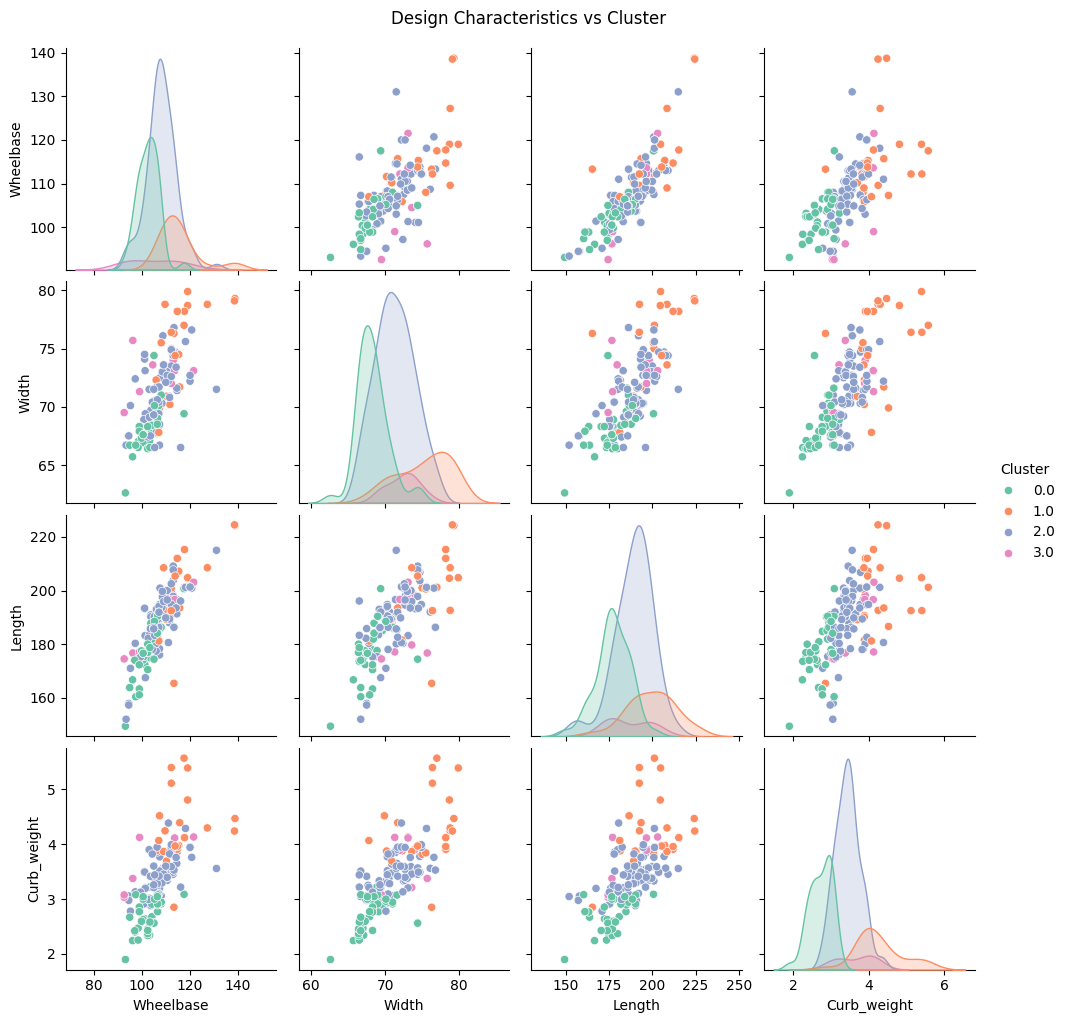

In [53]:
# Analyze clusters vs Sales, Resale Value, and design characteristics

# Assume df already has a 'Cluster' column from previous clustering step
# Example: df['Cluster'] = kmeans.labels_

# 1. Average Sales per Cluster
avg_sales = df.groupby('Cluster')['Sales_in_thousands'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=avg_sales, x='Cluster', y='Sales_in_thousands', palette='viridis')
plt.title("Average Sales per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Sales (in thousands)")
plt.show()

# 2. Average 1-Year Resale Value per Cluster
avg_resale = df.groupby('Cluster')['Year_resale_value'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=avg_resale, x='Cluster', y='Year_resale_value', palette='magma')
plt.title("Average 1-Year Resale Value per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Resale Value (in thousands)")
plt.show()

# 3. Design Characteristics per Cluster
# Features like Wheelbase, Width, Length, Curb_weight
design_features = ['Wheelbase', 'Width', 'Length', 'Curb_weight']
design_avg = df.groupby('Cluster')[design_features].mean().reset_index()

# Plot as multiple barplots
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

for i, feature in enumerate(design_features):
    sns.barplot(data=design_avg, x='Cluster', y=feature, palette='coolwarm', ax=axes[i])
    axes[i].set_title(f"Average {feature} per Cluster")
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

# 4. Optional: Pairplot to visualize cluster distribution over design features
sns.pairplot(df, vars=design_features, hue='Cluster', palette='Set2')
plt.suptitle("Design Characteristics vs Cluster", y=1.02)
plt.show()


In [55]:

# Calculate age relative to today
today = pd.Timestamp.today()
df['Age_days'] = (today - df['Latest_Launch']).dt.days
df['Age_years'] = df['Age_days'] // 365
df['Age_months'] = (df['Age_days'] % 365) // 30  # approximate months
df['Age_years_months'] = df['Age_years'].astype(str) + " yrs " + df['Age_months'].astype(str) + " mo"

# Check result
df[['Latest_Launch', 'Age_days', 'Age_years', 'Age_months', 'Age_years_months']].head()


,Latest_Launch,Age_days,Age_years,Age_months,Age_years_months
0,2012-02-02,4996,13,8,13 yrs 8 mo
1,2011-06-03,5240,14,4,14 yrs 4 mo
2,2012-01-04,5025,13,9,13 yrs 9 mo
3,2011-03-10,5325,14,7,14 yrs 7 mo
4,2011-10-08,5113,14,0,14 yrs 0 mo


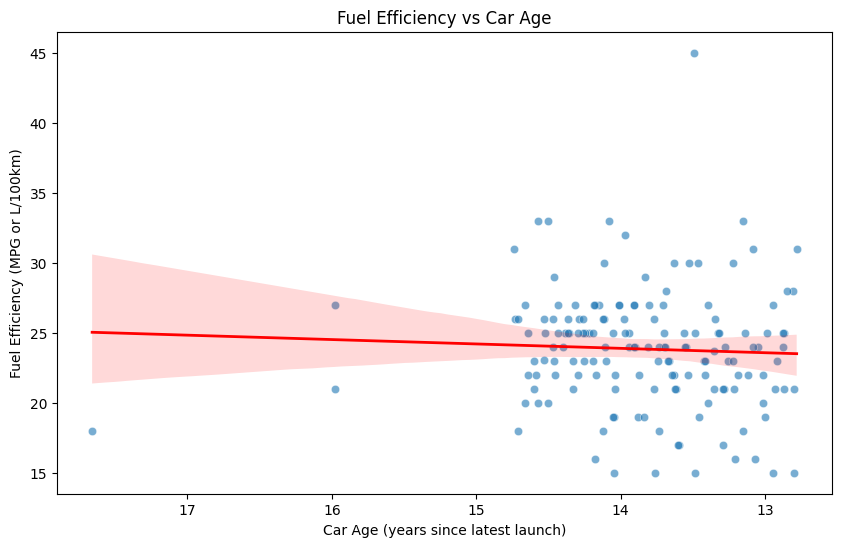

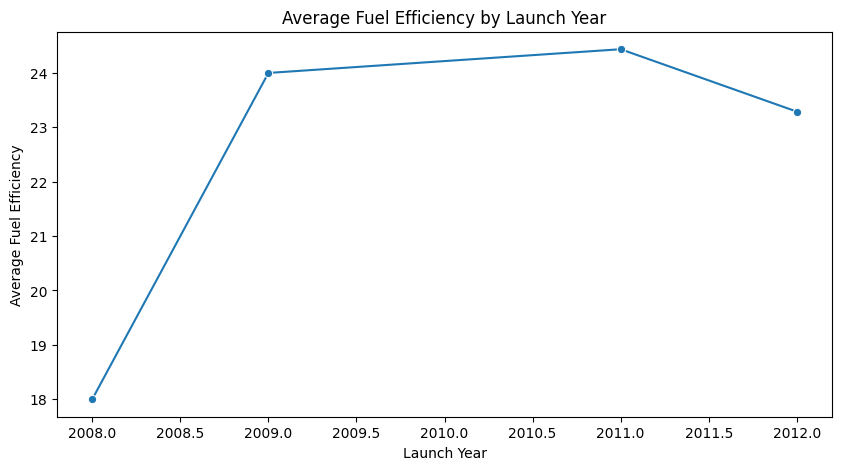

In [57]:
# Are newer cars more fuel-efficient?

# Ensure required columns exist
required_cols = ['Latest_Launch', 'Fuel_efficiency']  # Replace with actual column name
if all(col in df.columns for col in required_cols):

    # Convert Latest_Launch to datetime if not already
    df['Latest_Launch'] = pd.to_datetime(df['Latest_Launch'])

    # Calculate age in years relative to today
    today = pd.Timestamp.today()
    df['Age_years'] = (today - df['Latest_Launch']).dt.days / 365

    plt.figure(figsize=(10,6))
    
    # Scatter plot: Fuel Efficiency vs Age
    sns.scatterplot(
        data=df,
        x='Age_years',
        y='Fuel_efficiency',
        alpha=0.6
    )
    
    # Regression line to show trend
    sns.regplot(
        data=df,
        x='Age_years',
        y='Fuel_efficiency',
        scatter=False,
        color='red',
        line_kws={'linewidth':2}
    )
    
    plt.title("Fuel Efficiency vs Car Age")
    plt.xlabel("Car Age (years since latest launch)")
    plt.ylabel("Fuel Efficiency (MPG or L/100km)")
    plt.gca().invert_xaxis()  # Optional: show newer cars on left
    plt.show()
    
    # Optional: Average fuel efficiency by launch year
    df['Launch_Year'] = df['Latest_Launch'].dt.year
    avg_fuel = df.groupby('Launch_Year')['Fuel_efficiency'].mean()
    
    plt.figure(figsize=(10,5))
    sns.lineplot(x=avg_fuel.index, y=avg_fuel.values, marker='o')
    plt.title("Average Fuel Efficiency by Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Average Fuel Efficiency")
    plt.show()


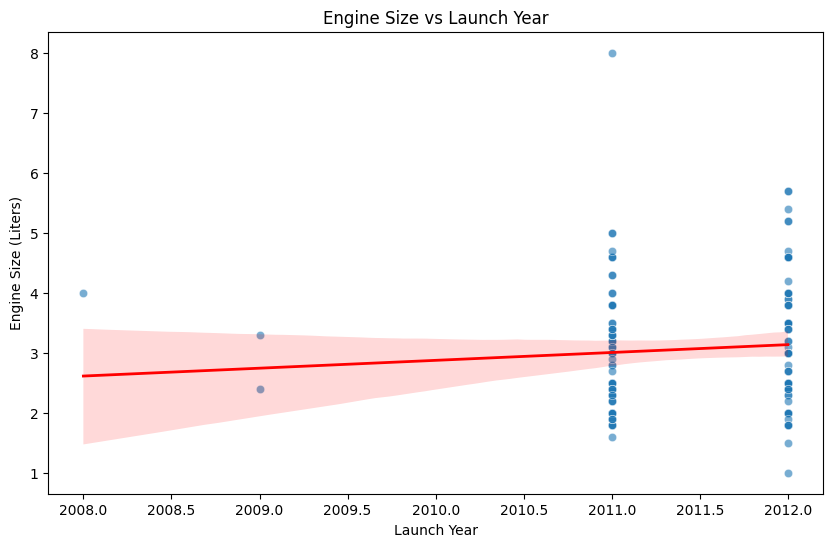

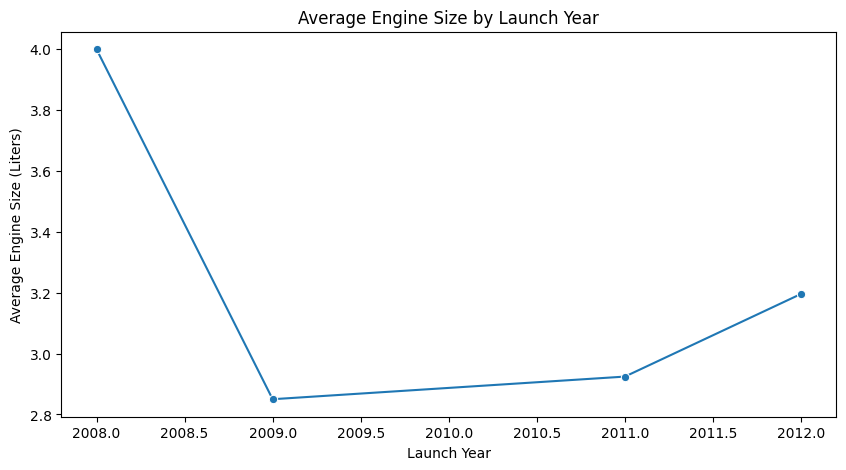

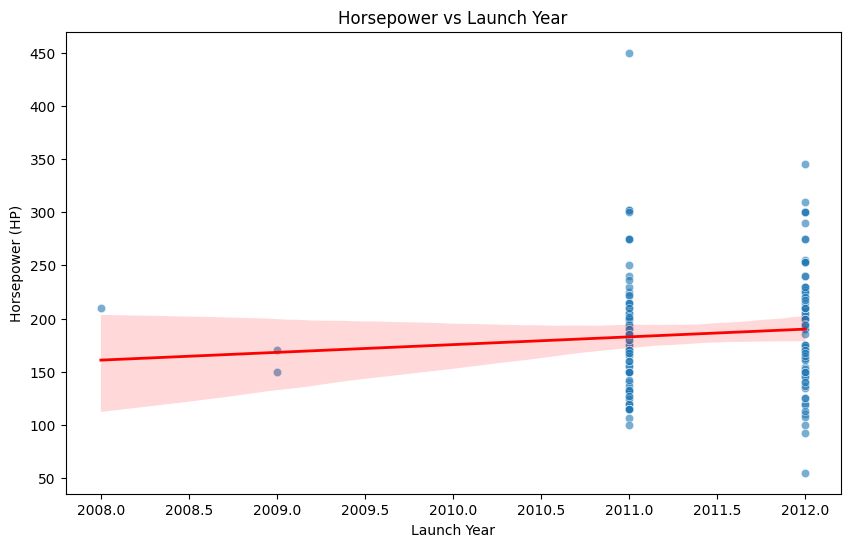

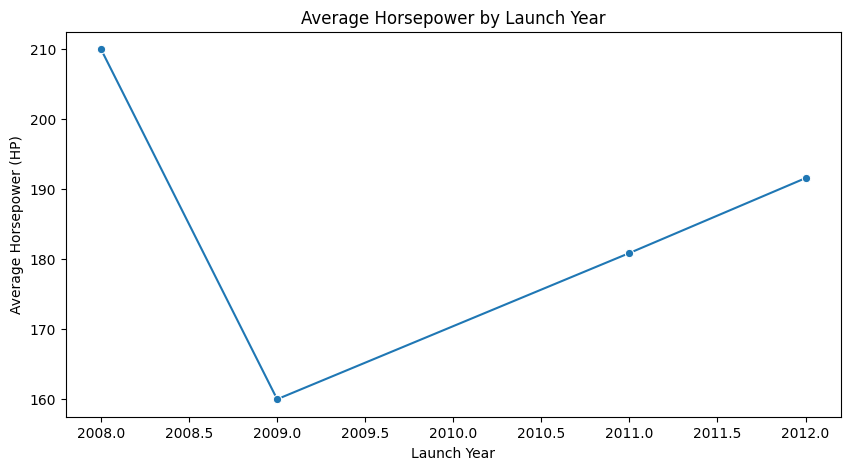

In [ ]:
# Engine Size and Horsepower vs Year / Launch
# Are engine sizes or horsepower increasing over time?

required_cols = ['Latest_Launch', 'Engine_size', 'Horsepower']
if all(col in df.columns for col in required_cols):

    # Convert Latest_Launch to datetime if not already
    df['Latest_Launch'] = pd.to_datetime(df['Latest_Launch'])
    df['Launch_Year'] = df['Latest_Launch'].dt.year

    # 1. Engine Size over time
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df, x='Launch_Year', y='Engine_size', alpha=0.6)
    sns.regplot(data=df, x='Launch_Year', y='Engine_size', scatter=False, color='red', line_kws={'linewidth':2})
    plt.title("Engine Size vs Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Engine Size (Liters)")
    plt.show()

    # Optional: Average engine size by year
    avg_engine = df.groupby('Launch_Year')['Engine_size'].mean()
    plt.figure(figsize=(10,5))
    sns.lineplot(x=avg_engine.index, y=avg_engine.values, marker='o')
    plt.title("Average Engine Size by Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Average Engine Size (Liters)")
    plt.show()

    # 2. Horsepower over time
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df, x='Launch_Year', y='Horsepower', alpha=0.6)
    sns.regplot(data=df, x='Launch_Year', y='Horsepower', scatter=False, color='red', line_kws={'linewidth':2})
    plt.title("Horsepower vs Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Horsepower (HP)")
    plt.show()

    # Optional: Average horsepower by year
    avg_hp = df.groupby('Launch_Year')['Horsepower'].mean()
    plt.figure(figsize=(10,5))
    sns.lineplot(x=avg_hp.index, y=avg_hp.values, marker='o')
    plt.title("Average Horsepower by Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Average Horsepower (HP)")
    plt.show()


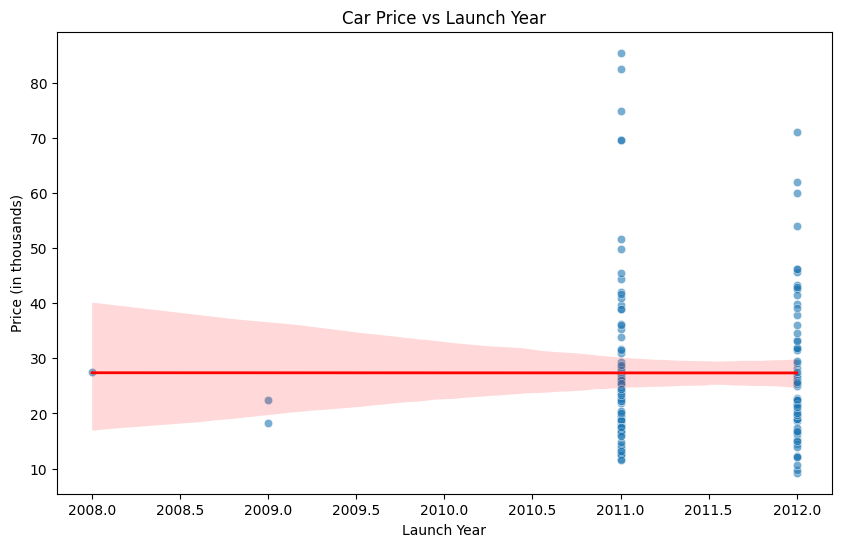

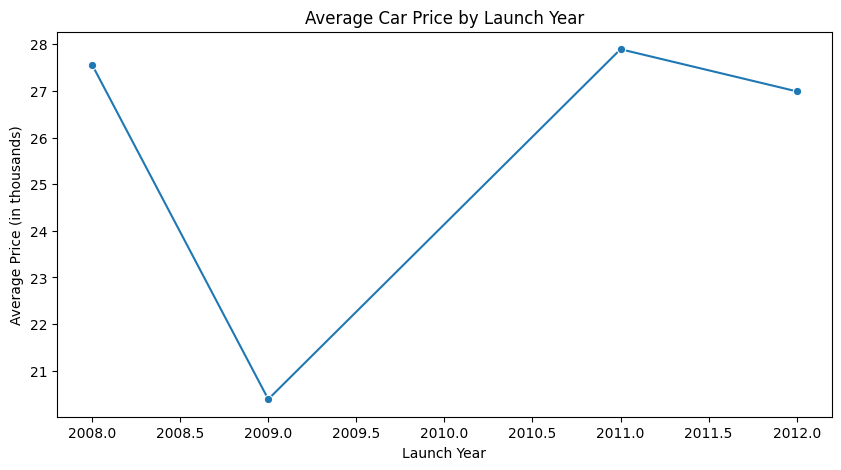

In [59]:
# Are newer cars more expensive?

required_cols = ['Latest_Launch', 'Price_in_thousands']
if all(col in df.columns for col in required_cols):

    # Convert Latest_Launch to datetime if not already
    df['Latest_Launch'] = pd.to_datetime(df['Latest_Launch'])
    df['Launch_Year'] = df['Latest_Launch'].dt.year

    # 1. Scatter plot of Price vs Launch Year
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=df,
        x='Launch_Year',
        y='Price_in_thousands',
        alpha=0.6
    )
    
    # Regression line to show trend
    sns.regplot(
        data=df,
        x='Launch_Year',
        y='Price_in_thousands',
        scatter=False,
        color='red',
        line_kws={'linewidth':2}
    )
    
    plt.title("Car Price vs Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Price (in thousands)")
    plt.show()

    # 2. Optional: Average price by launch year
    avg_price = df.groupby('Launch_Year')['Price_in_thousands'].mean()
    plt.figure(figsize=(10,5))
    sns.lineplot(x=avg_price.index, y=avg_price.values, marker='o')
    plt.title("Average Car Price by Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Average Price (in thousands)")
    plt.show()


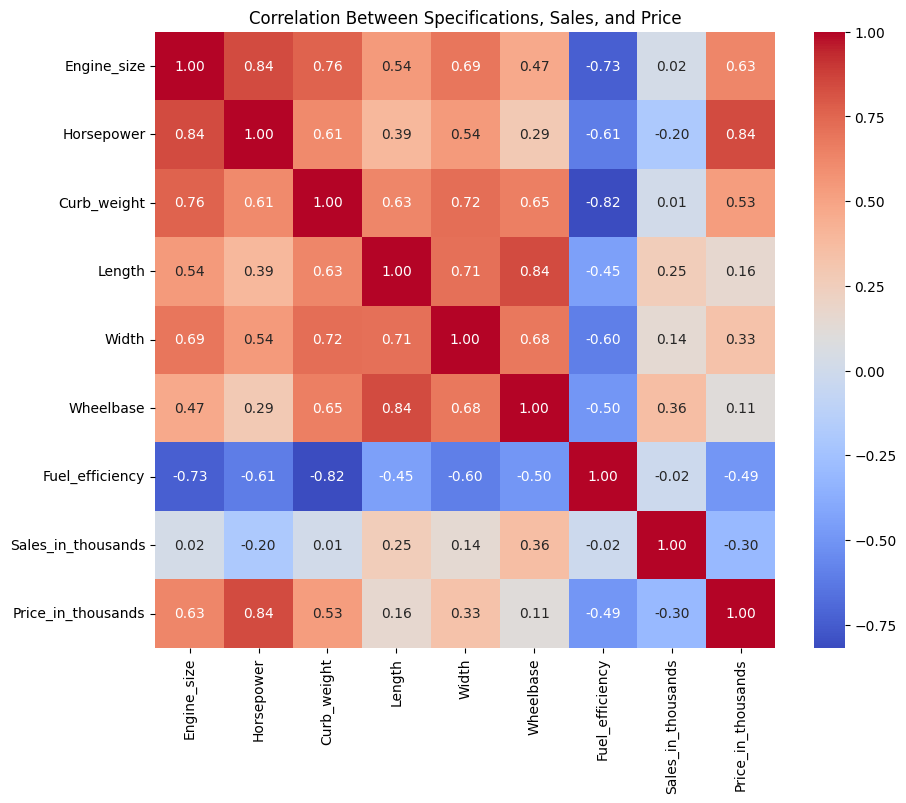

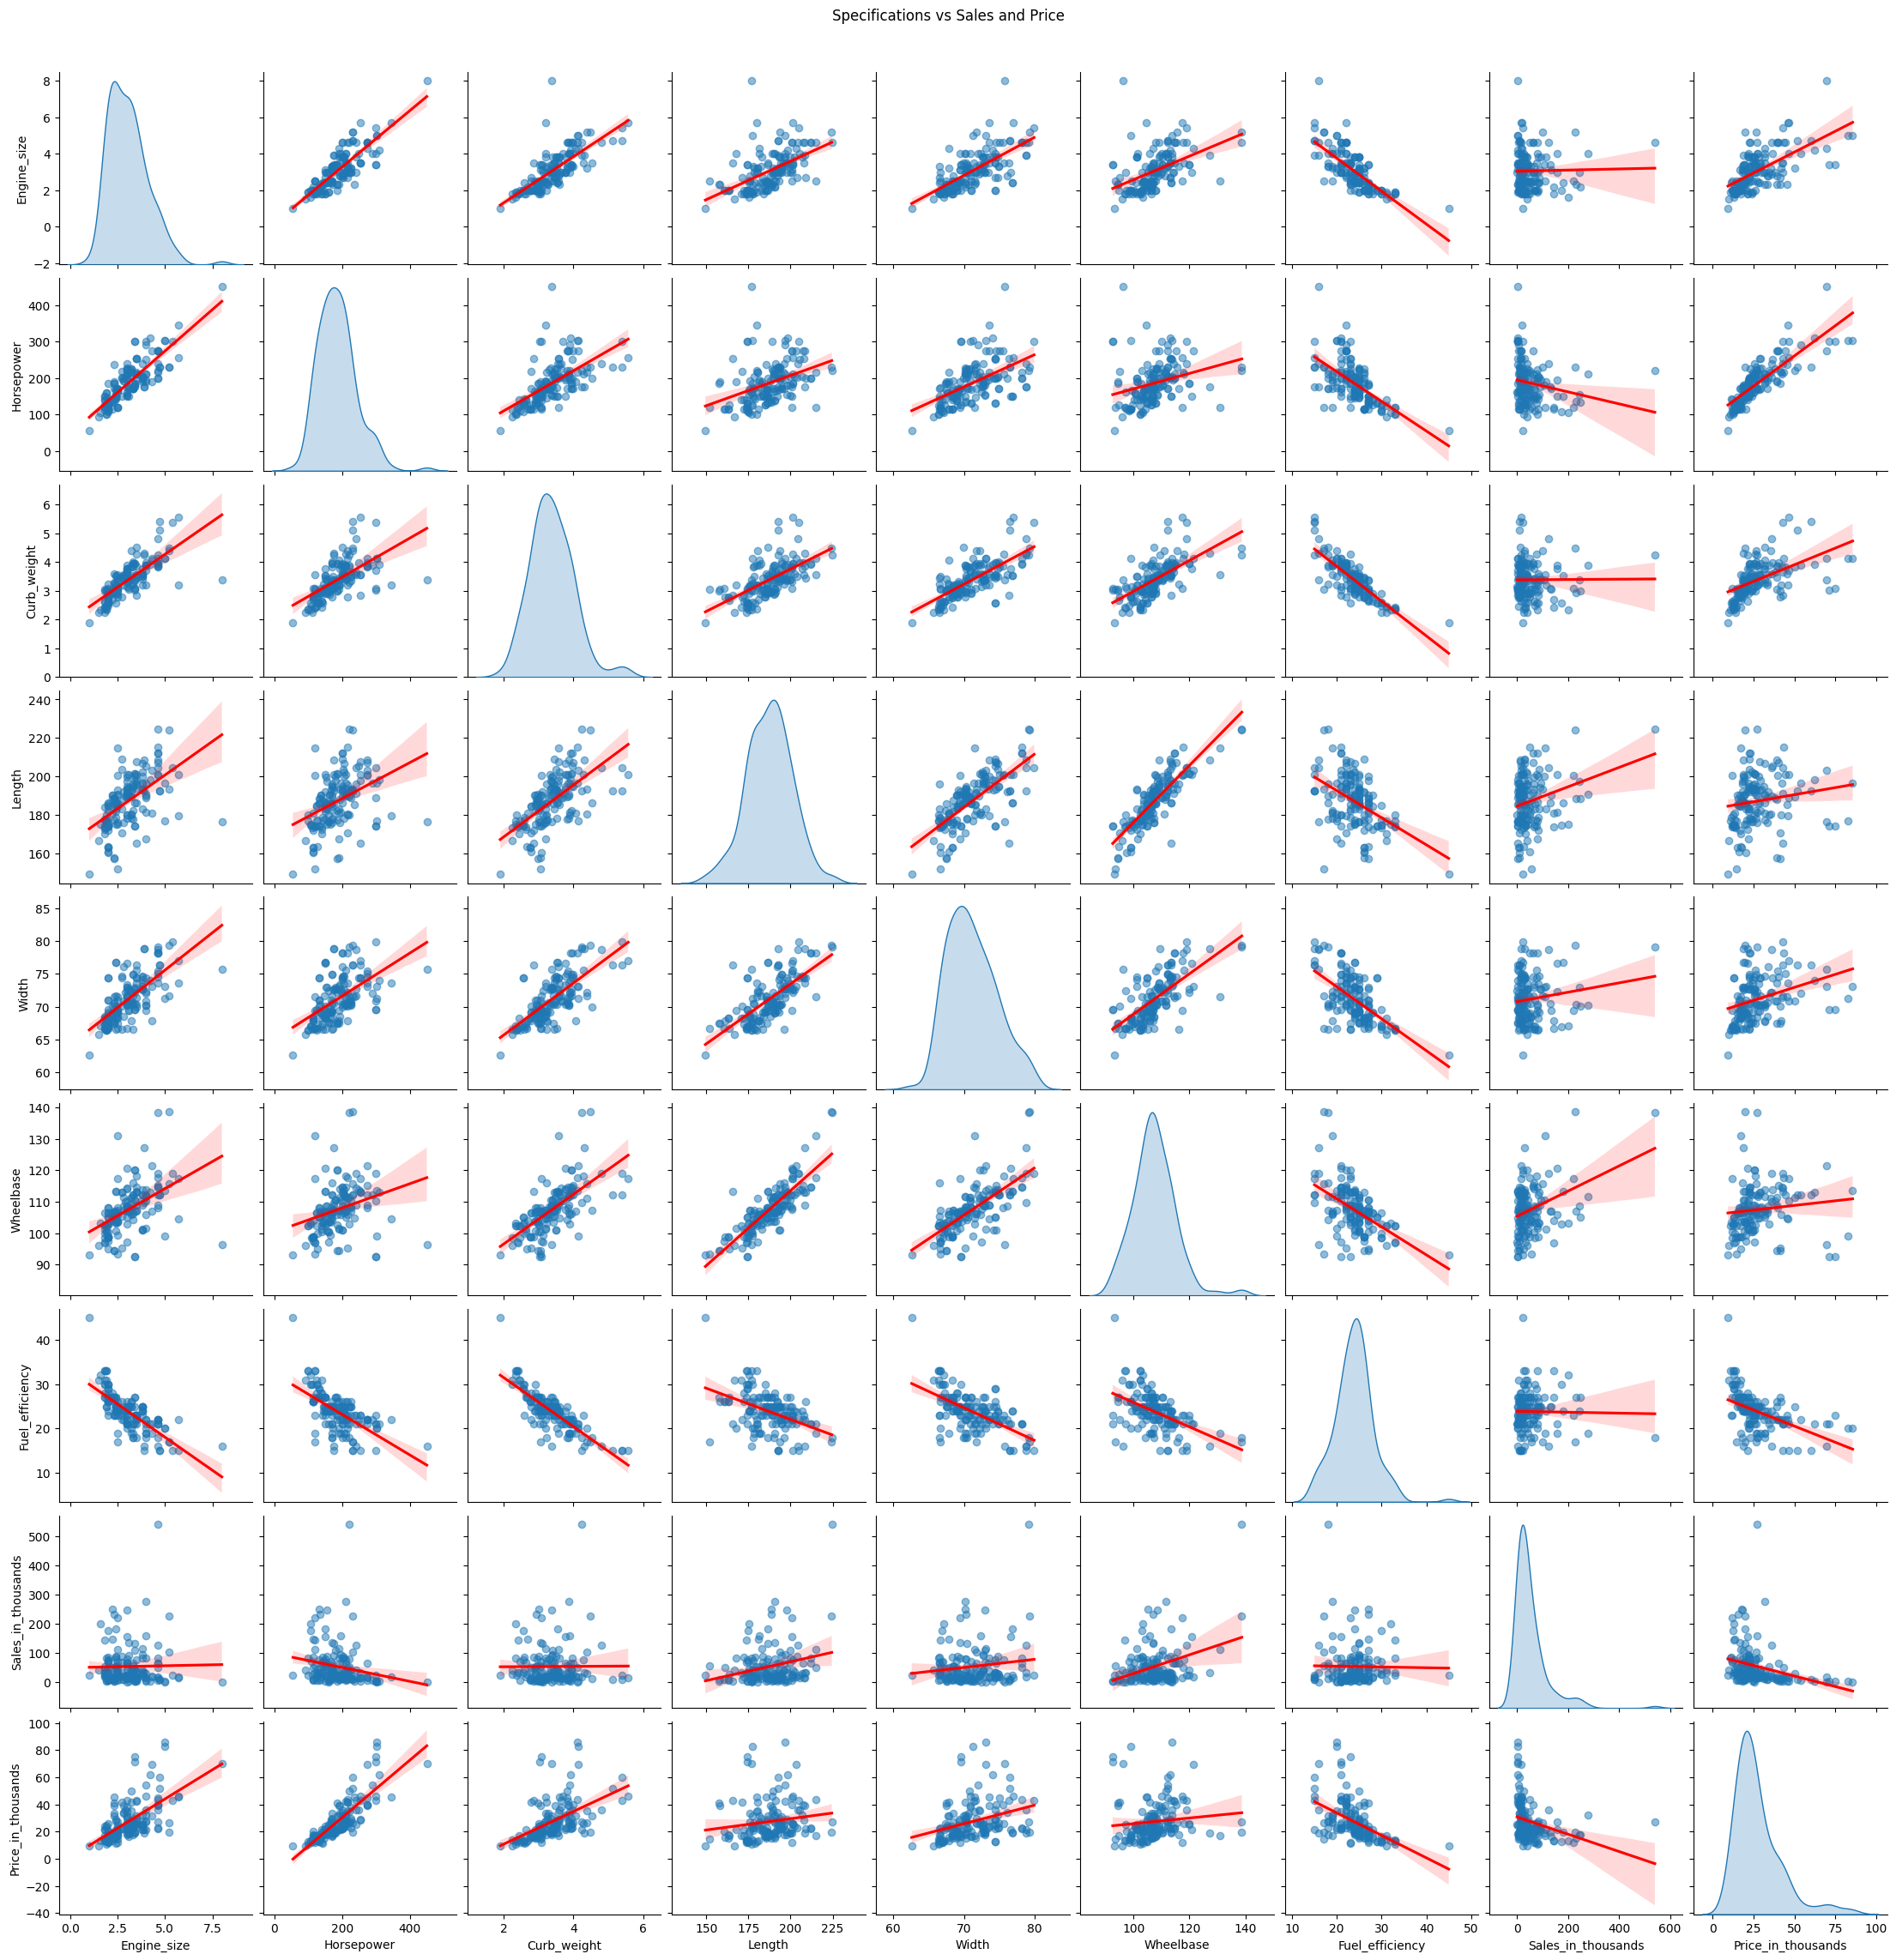

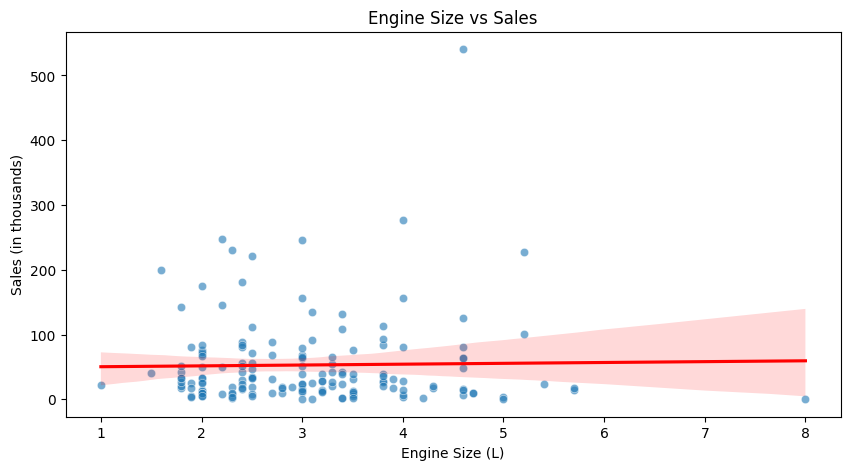

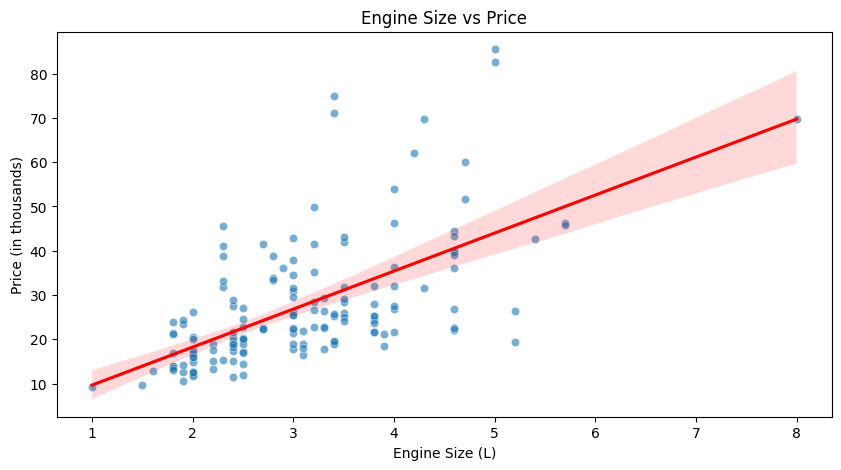

In [60]:
# How do specifications influence sales and price?
# Required columns
spec_cols = ['Engine_size', 'Horsepower', 'Curb_weight', 'Length', 'Width', 'Wheelbase', 'Fuel_efficiency', 'Sales_in_thousands', 'Price_in_thousands']
if all(col in df.columns for col in spec_cols):

    # 1. Correlation matrix
    corr = df[spec_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Between Specifications, Sales, and Price")
    plt.show()

    # 2. Pair plot to visualize relationships
    sns.pairplot(
        df[spec_cols],
        kind='reg',    # adds regression line
        diag_kind='kde', 
        plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha':0.5}}
    )
    plt.suptitle("Specifications vs Sales and Price", y=1.02)
    plt.show()

    # 3. Individual scatter plots for clarity (example: Engine size vs Sales & Price)
    plt.figure(figsize=(10,5))
    sns.scatterplot(x='Engine_size', y='Sales_in_thousands', data=df, alpha=0.6)
    sns.regplot(x='Engine_size', y='Sales_in_thousands', data=df, scatter=False, color='red')
    plt.title("Engine Size vs Sales")
    plt.xlabel("Engine Size (L)")
    plt.ylabel("Sales (in thousands)")
    plt.show()

    plt.figure(figsize=(10,5))
    sns.scatterplot(x='Engine_size', y='Price_in_thousands', data=df, alpha=0.6)
    sns.regplot(x='Engine_size', y='Price_in_thousands', data=df, scatter=False, color='red')
    plt.title("Engine Size vs Price")
    plt.xlabel("Engine Size (L)")
    plt.ylabel("Price (in thousands)")
    plt.show()


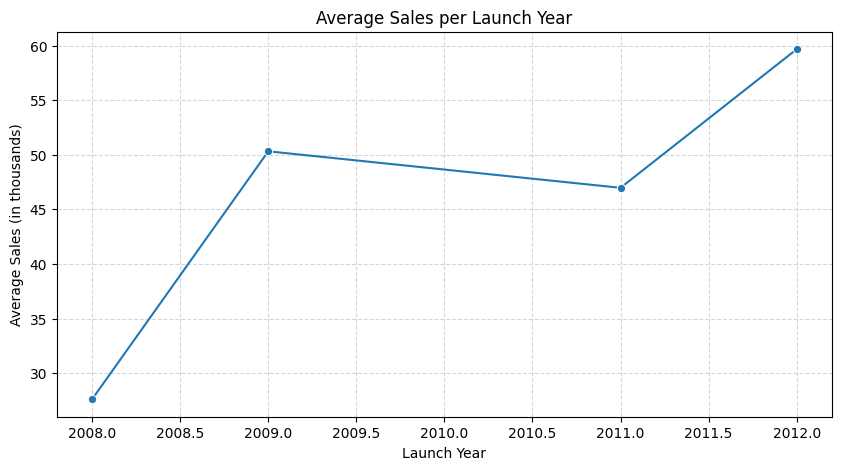

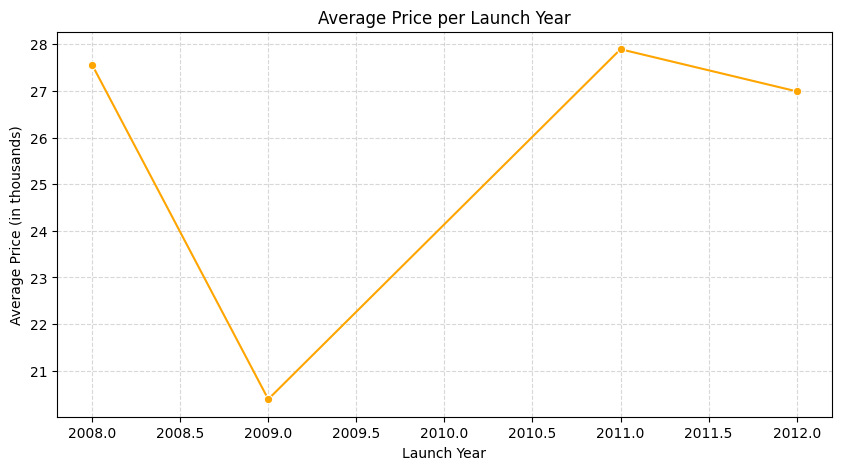

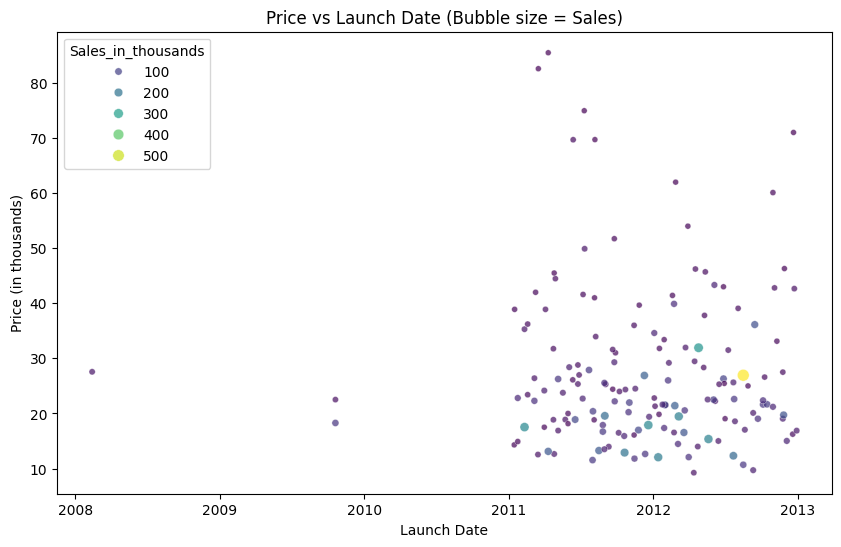

In [61]:
# How do sales and prices trend over time with new launches?
# Ensure necessary columns exist
required_cols = ['Latest_Launch', 'Sales_in_thousands', 'Price_in_thousands']
if all(col in df.columns for col in required_cols):

    # Convert Latest_Launch to datetime
    df['Latest_Launch'] = pd.to_datetime(df['Latest_Launch'], errors='coerce')

    # Extract Year and Month
    df['Launch_Year'] = df['Latest_Launch'].dt.year
    df['Launch_Month'] = df['Latest_Launch'].dt.month

    # 1. Average Sales per Launch Year
    sales_by_year = df.groupby('Launch_Year')['Sales_in_thousands'].mean()
    plt.figure(figsize=(10,5))
    sns.lineplot(x=sales_by_year.index, y=sales_by_year.values, marker='o')
    plt.title("Average Sales per Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Average Sales (in thousands)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # 2. Average Price per Launch Year
    price_by_year = df.groupby('Launch_Year')['Price_in_thousands'].mean()
    plt.figure(figsize=(10,5))
    sns.lineplot(x=price_by_year.index, y=price_by_year.values, marker='o', color='orange')
    plt.title("Average Price per Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Average Price (in thousands)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # 3. Optional: Scatter plot of individual models
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=df,
        x='Latest_Launch',
        y='Price_in_thousands',
        size='Sales_in_thousands',
        hue='Sales_in_thousands',
        palette='viridis',
        alpha=0.7
    )
    plt.title("Price vs Launch Date (Bubble size = Sales)")
    plt.xlabel("Launch Date")
    plt.ylabel("Price (in thousands)")
    plt.show()


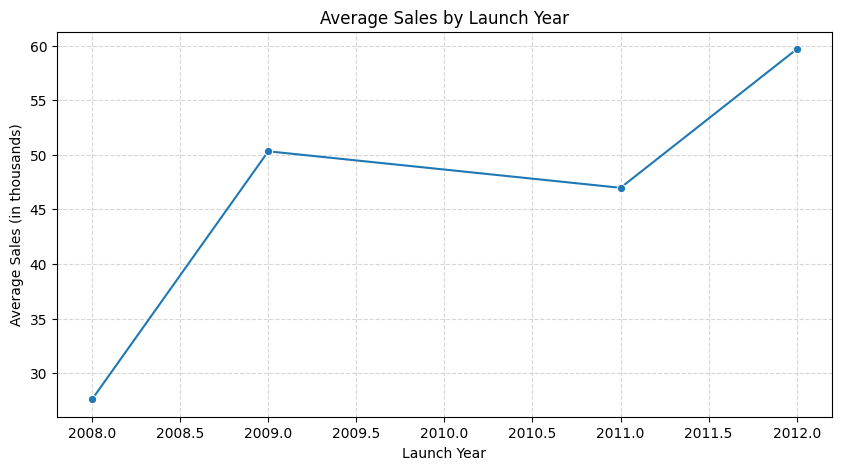

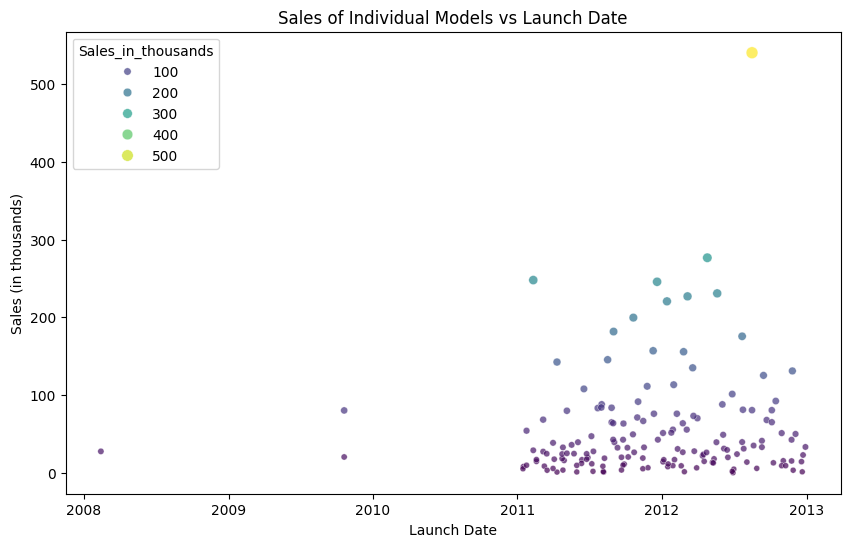

In [62]:
# Do recently launched models achieve higher sales?
# Ensure necessary columns exist
required_cols = ['Latest_Launch', 'Sales_in_thousands']
if all(col in df.columns for col in required_cols):

    # Convert Latest_Launch to datetime
    df['Latest_Launch'] = pd.to_datetime(df['Latest_Launch'], errors='coerce')

    # Extract Year and Month for aggregation
    df['Launch_Year'] = df['Latest_Launch'].dt.year
    df['Launch_Month'] = df['Latest_Launch'].dt.month

    # 1. Average sales by launch year
    avg_sales_by_year = df.groupby('Launch_Year')['Sales_in_thousands'].mean()
    plt.figure(figsize=(10,5))
    sns.lineplot(x=avg_sales_by_year.index, y=avg_sales_by_year.values, marker='o')
    plt.title("Average Sales by Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Average Sales (in thousands)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # 2. Scatter plot of individual models
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=df,
        x='Latest_Launch',
        y='Sales_in_thousands',
        hue='Sales_in_thousands',
        size='Sales_in_thousands',
        palette='viridis',
        alpha=0.7
    )
    plt.title("Sales of Individual Models vs Launch Date")
    plt.xlabel("Launch Date")
    plt.ylabel("Sales (in thousands)")
    plt.show()


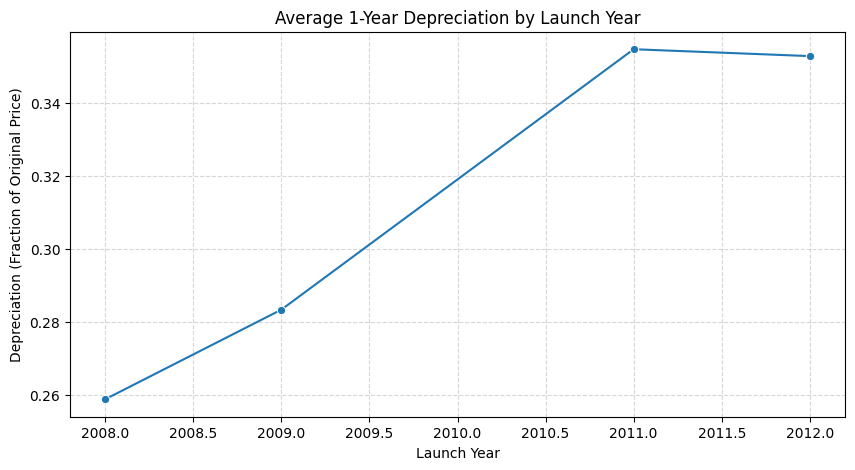

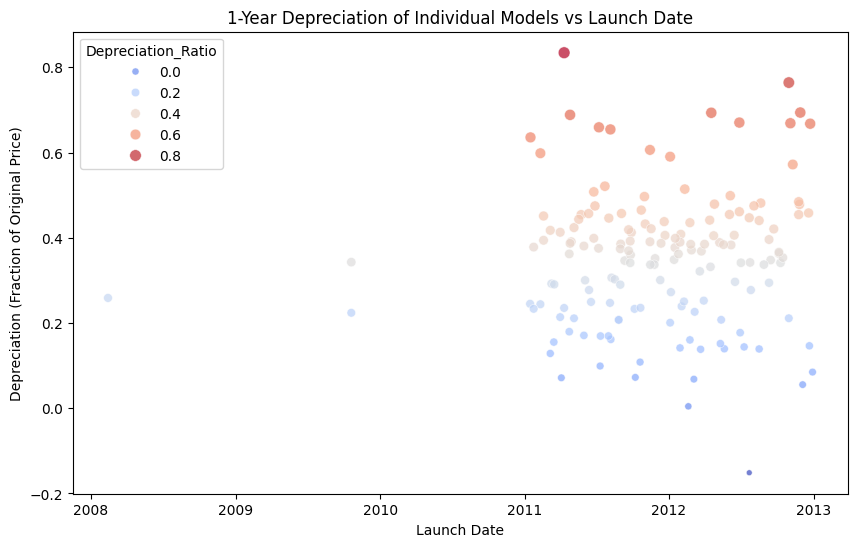

In [63]:
# How fast do cars depreciate after launch?
# Ensure necessary columns exist
required_cols = ['Latest_Launch', 'Price_in_thousands', 'Year_resale_value']
if all(col in df.columns for col in required_cols):

    # Convert Latest_Launch to datetime
    df['Latest_Launch'] = pd.to_datetime(df['Latest_Launch'], errors='coerce')

    # Calculate Depreciation Ratio = 1 - (Resale / Original Price)
    df['Depreciation_Ratio'] = 1 - (df['Year_resale_value'] / df['Price_in_thousands'])

    # Extract launch year
    df['Launch_Year'] = df['Latest_Launch'].dt.year

    # Average depreciation by launch year
    avg_depreciation = df.groupby('Launch_Year')['Depreciation_Ratio'].mean()

    # Plot average depreciation over launch years
    plt.figure(figsize=(10,5))
    sns.lineplot(x=avg_depreciation.index, y=avg_depreciation.values, marker='o')
    plt.title("Average 1-Year Depreciation by Launch Year")
    plt.xlabel("Launch Year")
    plt.ylabel("Depreciation (Fraction of Original Price)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # Scatter plot for individual models
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=df,
        x='Latest_Launch',
        y='Depreciation_Ratio',
        hue='Depreciation_Ratio',
        size='Depreciation_Ratio',
        palette='coolwarm',
        alpha=0.7
    )
    plt.title("1-Year Depreciation of Individual Models vs Launch Date")
    plt.xlabel("Launch Date")
    plt.ylabel("Depreciation (Fraction of Original Price)")
    plt.show()


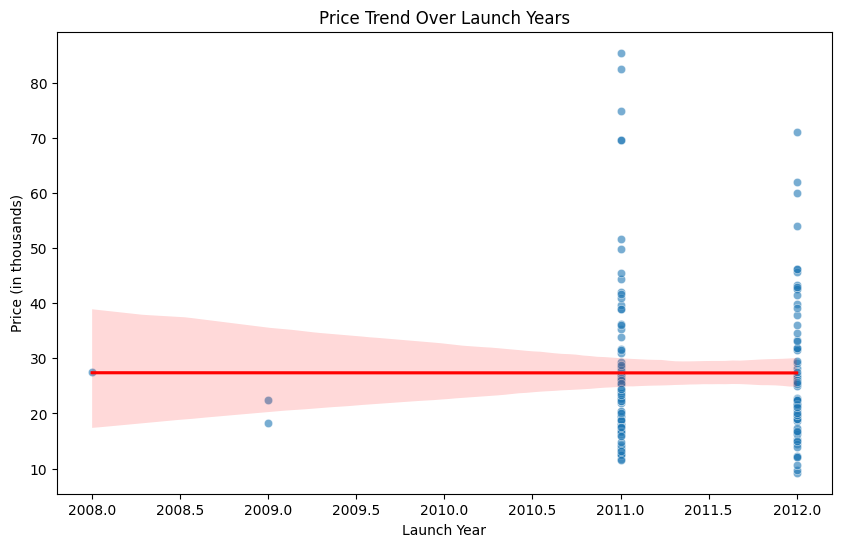

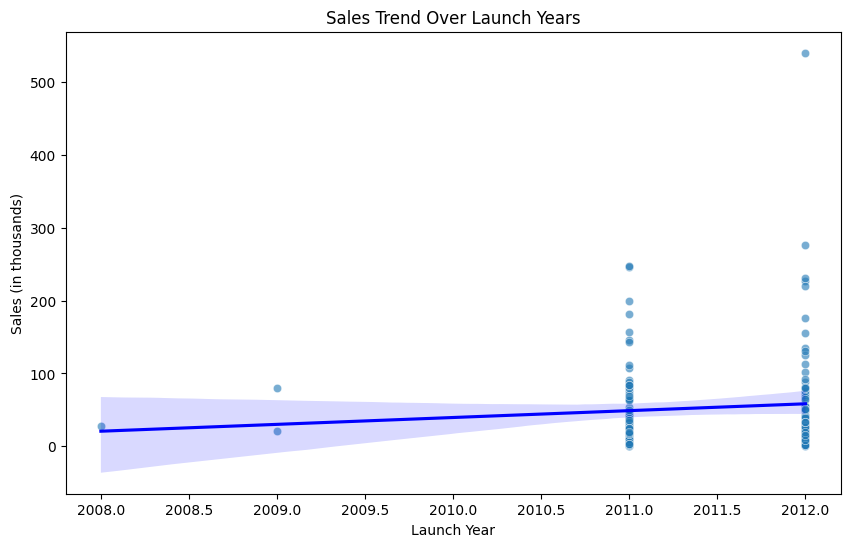

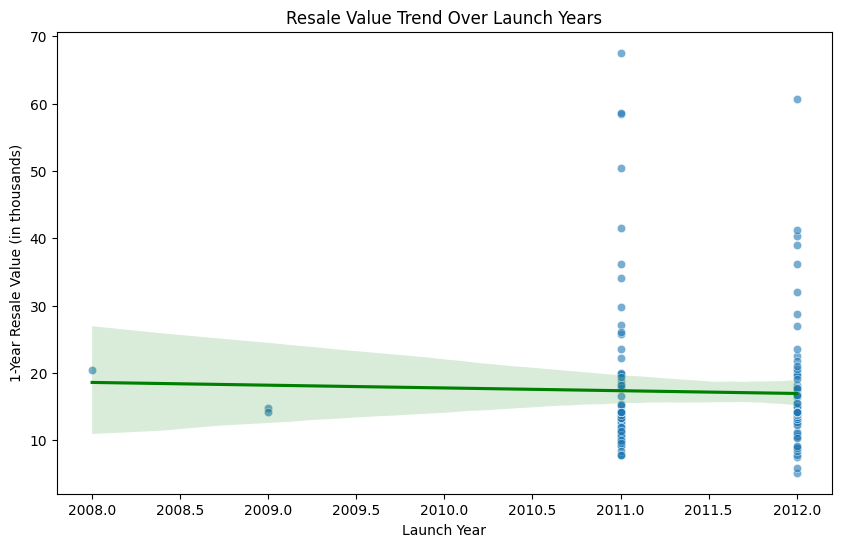

In [64]:
# Any pattern of sales, resale value and price trend over time with new launches?
# -----------------------------
# Pattern of Sales, Resale Value and Price over Time
# -----------------------------

required_cols = ['Latest_Launch', 'Sales_in_thousands', 'Year_resale_value', 'Price_in_thousands']
if all(col in df.columns for col in required_cols):

    # Convert Latest_Launch to datetime
    df['Latest_Launch'] = pd.to_datetime(df['Latest_Launch'], errors='coerce')
    df['Launch_Year'] = df['Latest_Launch'].dt.year

    # ---- Price Trend ----
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df, x='Launch_Year', y='Price_in_thousands', alpha=0.6)
    sns.regplot(data=df, x='Launch_Year', y='Price_in_thousands', scatter=False, color='red')
    plt.title("Price Trend Over Launch Years")
    plt.xlabel("Launch Year")
    plt.ylabel("Price (in thousands)")
    plt.show()

    # ---- Sales Trend ----
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df, x='Launch_Year', y='Sales_in_thousands', alpha=0.6)
    sns.regplot(data=df, x='Launch_Year', y='Sales_in_thousands', scatter=False, color='blue')
    plt.title("Sales Trend Over Launch Years")
    plt.xlabel("Launch Year")
    plt.ylabel("Sales (in thousands)")
    plt.show()

    # ---- Resale Value Trend ----
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df, x='Launch_Year', y='Year_resale_value', alpha=0.6)
    sns.regplot(data=df, x='Launch_Year', y='Year_resale_value', scatter=False, color='green')
    plt.title("Resale Value Trend Over Launch Years")
    plt.xlabel("Launch Year")
    plt.ylabel("1-Year Resale Value (in thousands)")
    plt.show()
